In [1]:
import cv2
import os
import re
import torch
import torchvision
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from matplotlib import pyplot as plt
import pandas as pd
from ast import literal_eval
import numpy as np
import albumentations as A

In [2]:
folders = ['Czech/','India/']

In [3]:
class RoadDamageDataset(Dataset):

    def __init__(self, dataframe, root_dir, folders, transform,train=True):
        super().__init__()
        self.data_df = dataframe
        self.transforms = transforms
        self.root_dir = root_dir
        self.folders = folders
        self.transform = transform
    def __len__(self) -> int:
        return self.data_df.shape[0]
    def __getitem__(self, idx: int):
        for folder in folders:
            if idx < 1072:
                folder = 'Czech/'
            else:
                folder = 'India/'
            path_to_img = os.path.join(self.root_dir, folder,'images/',self.data_df['image_id'].iloc[idx])
            img = cv2.imread(path_to_img)
            bboxes = torch.tensor((literal_eval(self.data_df['bboxes'].iloc[idx])))
            labels = torch.tensor((literal_eval(self.data_df['label'].iloc[idx])))+1
            target = {}
            target['boxes'] = bboxes
            target['labels'] = labels
            if self.transform is not None:
                transformed = self.transform(image=img, bboxes=bboxes, labels=labels)
                img = transformed["image"]
                bboxes = transformed["bboxes"]
                labels = transformed["labels"]
                target['boxes'] = torch.tensor(bboxes)
                target['labels'] = torch.tensor(labels)
        return img, target

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
data_df = pd.read_csv('data.csv')

In [6]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        #A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        #A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc',label_fields = ['labels']))

train_dataset = RoadDamageDataset(data_df,'C:/Users/User/Downloads/5ty2wb6gvg-1/train/',folders,transform=train_transform)


In [7]:
train_dataloader = DataLoader(train_dataset,batch_size = 2,shuffle = True, collate_fn=collate_fn)

In [8]:
class Averager:      ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [9]:
for images, targets in train_dataloader:
    break

In [10]:
torch.tensor(images).shape

C:\Users\User\AppData\Local\Temp\ipykernel_8760\1420290334.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  torch.tensor(images).shape


torch.Size([2, 256, 256, 3])

In [11]:
images,targets

((array([[[  5,  45,  38],
          [  6,  41,  34],
          [  4,  34,  29],
          ...,
          [254, 252, 244],
          [254, 252, 244],
          [254, 252, 244]],
  
         [[ 21,  56,  50],
          [  5,  36,  31],
          [ 20,  46,  42],
          ...,
          [254, 252, 244],
          [254, 252, 244],
          [254, 252, 244]],
  
         [[  2,  29,  25],
          [  9,  34,  29],
          [ 12,  35,  31],
          ...,
          [254, 252, 244],
          [254, 252, 244],
          [254, 252, 244]],
  
         ...,
  
         [[ 56,  86, 105],
          [ 52,  82, 101],
          [ 56,  85, 105],
          ...,
          [ 75,  87,  87],
          [ 71,  83,  83],
          [ 72,  84,  84]],
  
         [[ 52,  82, 100],
          [ 59,  89, 108],
          [ 52,  81, 100],
          ...,
          [ 76,  89,  89],
          [ 73,  85,  85],
          [ 70,  82,  82]],
  
         [[ 56,  86, 103],
          [ 58,  88, 105],
          [ 55,  85, 102

In [12]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True, )
num_classes = 11  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


model.train()
model.cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)
#l r_scheduler = None

num_epochs = 5

loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets in train_dataloader:
        targets = [{k: v.cuda() for k, v in t.items()} for t in targets]

        loss_dict = model(torch.tensor(images).permute(0,3,1,2).cuda().float(), targets)   ##Return the loss

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)  #Average out the loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        #print(loss_value)
        #
        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
C:\Users\User\AppDa

Iteration #50 loss: 0.30996253599519646
Iteration #100 loss: 0.5835117286630105
Iteration #150 loss: 0.7207912794281149
Iteration #200 loss: 0.2706433540169575
Iteration #250 loss: 0.22252234833773946
Iteration #300 loss: 0.3659378792846172
Iteration #350 loss: 0.534810364103057
Iteration #400 loss: 0.1811892114096655
Iteration #450 loss: 0.6444147810042431
Iteration #500 loss: 0.19106796694486294
Iteration #550 loss: 0.16086559723307498
Iteration #600 loss: 0.4047645559494114
Iteration #650 loss: 0.30224280708796836
Iteration #700 loss: 0.13928790863279497
Iteration #750 loss: 0.6062403821223673
Iteration #800 loss: 0.16930884494361462
Iteration #850 loss: 0.2690345082338495
Iteration #900 loss: 0.30364237409290623
Iteration #950 loss: 0.5808302453627221
Iteration #1000 loss: 0.2707832652188591
Iteration #1050 loss: 0.28919460318657675
Iteration #1100 loss: 0.36911690965814525
Iteration #1150 loss: 0.25430273660330915
Iteration #1200 loss: 0.2378317519875476
Iteration #1250 loss: 0.48

KeyboardInterrupt: 

In [13]:
model.eval();

In [14]:
model.

SyntaxError: invalid syntax (1068564517.py, line 1)

In [101]:
for images,_ in train_dataloader:
    break

In [102]:
outputs = model(torch.tensor([images[0]]).permute(0,3,1,2).cuda().float())

OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 4.00 GiB total capacity; 3.41 GiB already allocated; 0 bytes free; 3.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
detection_threshold = 0.2

In [ ]:
outputs[0]

In [ ]:
boxes = outputs[0]['boxes'].data.cpu().numpy()    ##Formate of the output's box is [Xmin,Ymin,Xmax,Ymax]
scores = outputs[0]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32) #Compare the score of output with the threshold and
scores = scores[scores >= detection_threshold] 

In [ ]:
tmp = images[1].copy()

In [ ]:
bbox[0],bbox[1],bbox[2],bbox[3]

In [98]:
#for bbox in boxes:
#    cv2.rectangle(tmp[0],(bbox[0].numpy()[0],bbox[1].numpy()[0]),(bbox[2].numpy()[0],bbox[3].numpy()[0]),(0,255,0), 5)
    
for bbox in boxes:
    cv2.rectangle(tmp,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,255,0), 2)

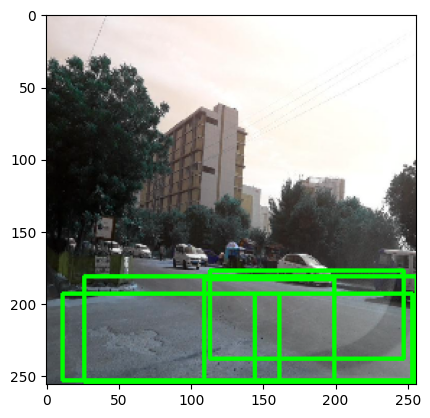

In [99]:
plt.imshow(tmp)

In [100]:
loss_dict

{'loss_classifier': tensor(0.1820, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1196, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0475, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0150, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)}